In [10]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [11]:
#Defining date range for historical analysis
START_DATE = datetime(2016, 1, 1)
END_DATE = datetime(2020, 1, 1)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)
#try from 2016
#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

In [12]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)
    
    return df_fs

In [13]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2016-01-01,110,10295906
1,2016-01-02,113,10073713
2,2016-01-03,113,9864833
3,2016-01-04,122,10517336
4,2016-01-05,117,9842739
...,...,...,...
1457,2019-12-28,153,9124341
1458,2019-12-29,131,8405414
1459,2019-12-30,124,7936358
1460,2019-12-31,131,8213431


Text(0, 0.5, 'Floating Storage (t)')

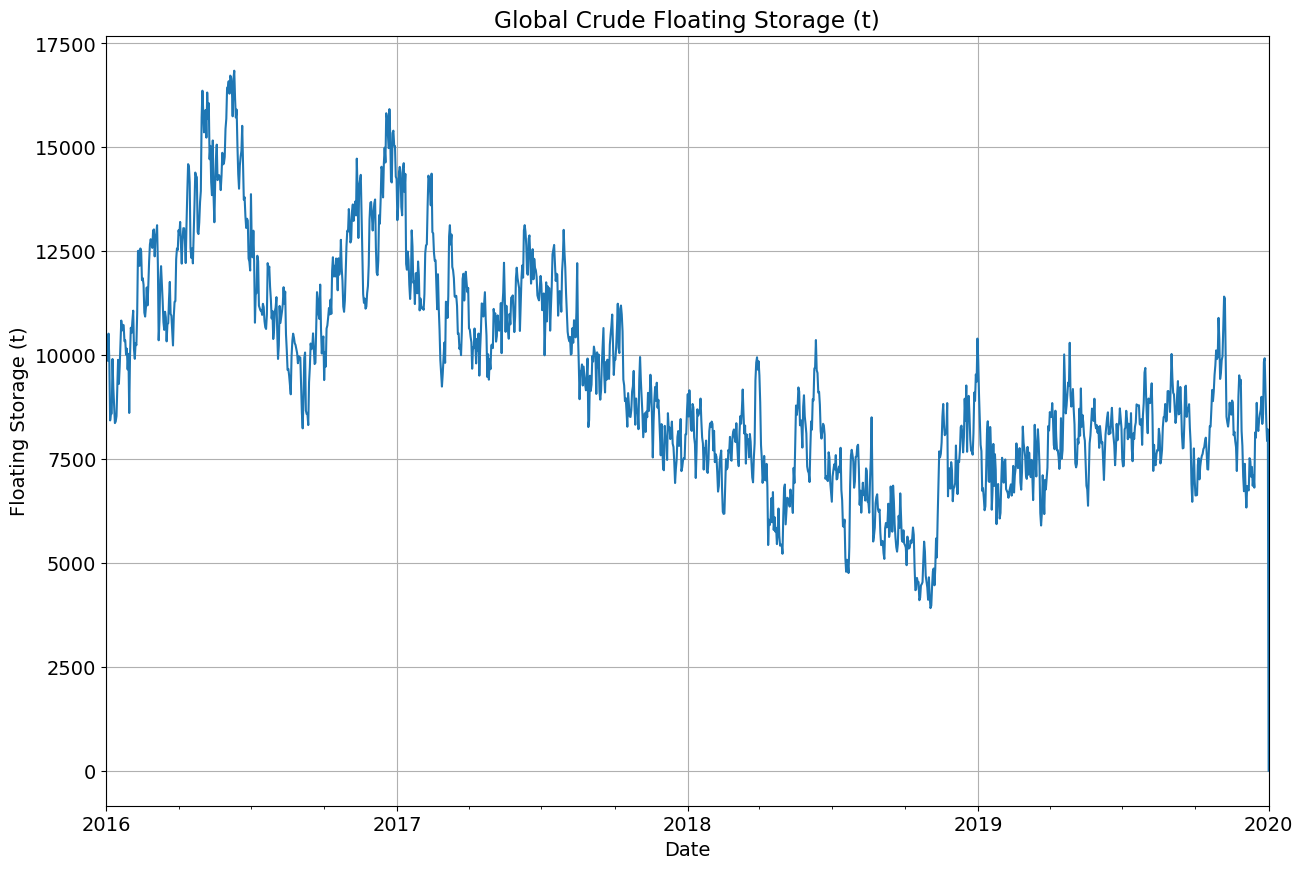

In [14]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

In [15]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
spot_prices

,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2016-01-01,37.13,36.61
2016-01-02,37.13,36.61
2016-01-03,37.13,36.61
2016-01-04,36.81,36.28
2016-01-05,35.97,35.56
...,...,...
2019-12-28,61.76,68.91
2019-12-29,61.76,68.91
2019-12-30,61.66,68.30
2019-12-31,61.14,67.77


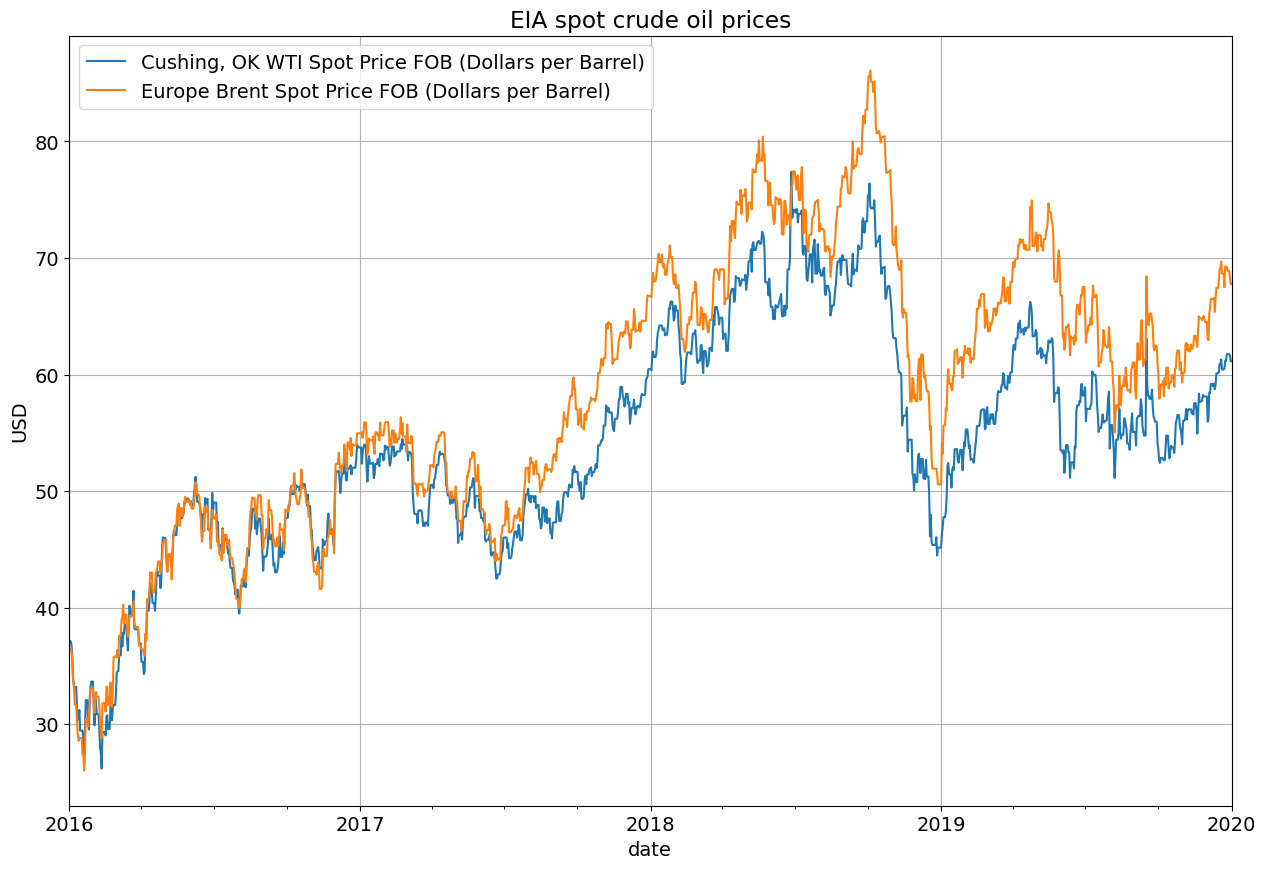

In [16]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');
#remove dates where crude oil prices are nrgative